### **Linear regression with iterative optimization: SGDRegressor** 

In this notebook, we will build linear regression model, with `SGDRegressor`. 

SGD offers a lot of control over optimization procedure through a number of hyperparameters. However, we need to set them to right values in order to make it work for training the model.

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor

In [2]:
np.random.seed(306)
plt.style.use('seaborn')

We will use `ShuffleSplit` as a cross validation strategy.

In [3]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

### STEP 1:  **Load the dataset**

In [4]:
features ,labels = fetch_california_housing(as_frame=True, return_X_y=True)

### STEP 2 :  **Preprocessing**

Split data into training and test sets.

In [5]:
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

Divide the training data into train and dev sets.

In [6]:
train_features ,dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42)

### STEP 3 :  **Model Building**

#### **Baseline SGDRegressor**

* Step 1 : To begin with, we instantiate a baseline `SGDRegressor` model with default parameters.

* Step 2 : Train the model with training feature matrix and labels.

* Step 3 : Obtain the score on the training and dev data.

In [7]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels) 

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features)) 
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features)) 

print('Train MAE: ', train_mae)
print('Dev MAE: ', dev_mae)

Train MAE:  309190327803747.2
Dev MAE:  311959782899622.1


We can observe that the mean absolute error is too high. The baseline model doesn't train well. This may happen due to large learning rate.

Let's investigate this issue by training the model step by step and recording training loss in each step.

#### **Adding a feature scaling step** 

We know that, SGD is sensitive to feature scaling. Let's add a feature scaling step and check if we get better MAE.

In [8]:
sgd_pipeline = Pipeline([
    ('scaler' , StandardScaler()),
    ('sgd' , SGDRegressor())
])

sgd_pipeline.fit(train_features, train_labels) 

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))

print('Train MAE: ', train_mae)
print('Dev MAE: ', dev_mae)

Train MAE:  309190327803747.2
Dev MAE:  311959782899622.1


The error is still high. 

**Let's run `SGDRegressor` step by step and investigate issues with training :** 

* Step 1 : Instantiate `SGDRegressor`  with `warm_start = True` and `tol=-np.infty`.

* Step 2 : Train SGD step by step and record regression loss in each step.

* Step 3 : Plot learning curves and see if there are any issues in training.

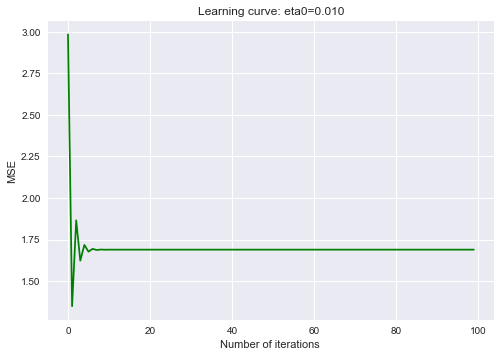

In [9]:
eta0 = 1e-2 
sgd_pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=1, tol = -np.infty, warm_start=True, random_state=42))
])

loss = [] 

for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels) #continues where it left off 
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features))) 

plt.plot(np.arange(len(loss)), loss, 'g-')

plt.xlabel('Number of iterations ')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.3f}')
plt.show()

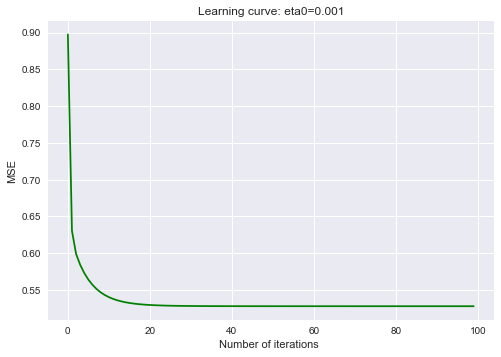

In [10]:
eta0 = 1e-3
sgd_pipeline = Pipeline([
                        ('feature_scaling', StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=1, tol = -np.infty, warm_start=True, eta0=eta0,random_state=42))
])

loss = [] 

for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels) 
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features))) 

plt.plot(np.arange(len(loss)), loss, 'g-')

plt.xlabel('Number of iterations ')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.3f}')
plt.show()

The is an ideal learning curve where the train loss reduces monotonically as the training progresses.

In [11]:
print("Number of iteration before reaching convergence criteria :",sgd_pipeline[-1].n_iter_)

print("Number of weight updates : ", sgd_pipeline[-1].t_)

Number of iteration before reaching convergence criteria : 1
Number of weight updates :  11611.0


**Checking train and dev mean absolute error.**

In [12]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print('Train MAE: ', train_mae)
print('Dev MAE: ', dev_mae)

Train MAE:  0.5333732983042573
Dev MAE:  0.5190150280908042


#### **Fixing learning rate through validation curves**


* Step 1 : Provide the list of values to be tried for a hyperparameter.

* Step 2 : Instantiate an object of `validation_curve` with estimator, training features and label. Set `scoring` parameter to relevant score.

* Step 3 : Convert scores to error. 

* Step 4 : Plot validation curve with the value of hyper-parameter on x-axis and error on the y-axis

* Step 5 : Fix the hyper-parameter value where the test error is the least.

In [13]:
%%time
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]

train_scores, test_scores = validation_curve(
    sgd_pipeline, com_train_features, com_train_labels, param_name="sgd__eta0", param_range=eta0, cv=shuffle_split_cv, scoring='neg_mean_squared_error', n_jobs=2
)

Wall time: 1.86 s


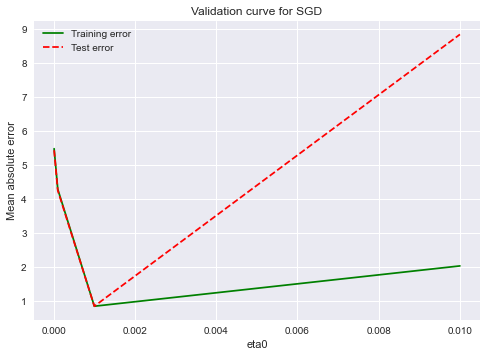

In [14]:
train_errors, test_errors = -train_scores, -test_scores

plt.plot(eta0, train_errors.mean(axis=1),'g-x',label='Training error')
plt.plot(eta0, test_errors.mean(axis=1),'r--x', label='Test error')

plt.legend() 
plt.xlabel('eta0')
plt.ylabel('Mean absolute error')
plt.title('Validation curve for SGD')
plt.show()

For `eta0=1e-3`, the test error is the least and hence we select that value as the value for `eta0`. 

Next we also plot standard deviation in errors.

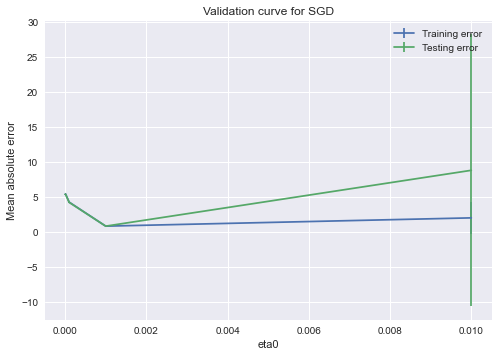

In [15]:
plt.errorbar(eta0, train_errors.mean(axis=1), yerr=train_errors.std(axis=1), label='Training error')

plt.errorbar(eta0, test_errors.mean(axis=1),yerr=test_errors.std(axis=1), label='Testing error')

plt.legend(loc='best') 
plt.xlabel('eta0')
plt.ylabel('Mean absolute error')
plt.title('Validation curve for SGD')
plt.show()

#### **Experimenting with learning rate parameter**

##### 1. No learning rate parameter

In [16]:
sgd_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=500,
                        early_stopping=True,
                        eta0=1e-3,
                        tol=1e-3,
                        validation_fraction=0.2,
                        n_iter_no_change=5,
                        average=10,
                        random_state=42))
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))

dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print('Train MAE: ', train_mae)
print('Dev MAE: ', dev_mae)
print()

# development set dev set
print('Number of SGD iterations :', sgd_pipeline[-1].n_iter_)
print('Number of weight updates : ', sgd_pipeline[-1].t_)

Train MAE:  0.5433287489797834
Dev MAE:  0.5345612073911922

Number of SGD iterations : 35
Number of weight updates :  406351.0


##### 2. learning rate = 'constant'

In [17]:
sgd_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=500,
                         early_stopping=True,
                         eta0=1e-3,
                         tol=1e-3,
                         learning_rate= 'constant',
                         validation_fraction=0.2,
                         n_iter_no_change=5,
                         average=10,
                         random_state=42))
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(
    train_labels, sgd_pipeline.predict(train_features))

dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print('Train MAE: ', train_mae)
print('Dev MAE: ', dev_mae)
print()

# development set dev set
print('Number of SGD iterations :', sgd_pipeline[-1].n_iter_)
print('Number of weight updates : ', sgd_pipeline[-1].t_)


Train MAE:  0.5528203432984674
Dev MAE:  0.5689568216133667

Number of SGD iterations : 11
Number of weight updates :  127711.0


##### 3. learning rate = 'adaptive'

In [18]:
sgd_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=500,
                         early_stopping=True,
                         eta0=1e-3,
                         tol=1e-3,
                         learning_rate='adaptive',
                         validation_fraction=0.2,
                         n_iter_no_change=5,
                         average=10,
                         random_state=42))
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(
    train_labels, sgd_pipeline.predict(train_features))

dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print('Train MAE: ', train_mae)
print('Dev MAE: ', dev_mae)
print()

# development set dev set
print('Number of SGD iterations :', sgd_pipeline[-1].n_iter_)
print('Number of weight updates : ', sgd_pipeline[-1].t_)


Train MAE:  0.5375525445454805
Dev MAE:  0.5200254740759911

Number of SGD iterations : 40
Number of weight updates :  464401.0


#### **Setting `max_iters` parameter**

In [19]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [20]:
sgd_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=max_iter,
                         early_stopping=True,
                         eta0=1e-3,
                         tol=1e-3,
                         learning_rate='adaptive',
                         validation_fraction=0.2,
                         n_iter_no_change=5,
                         average=10,
                         random_state=42))
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(
    train_labels, sgd_pipeline.predict(train_features))

dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print('Train MAE: ', train_mae)
print('Dev MAE: ', dev_mae)
print()

# development set dev set
print('Number of SGD iterations :', sgd_pipeline[-1].n_iter_)
print('Number of weight updates : ', sgd_pipeline[-1].t_)

Train MAE:  0.5375525445454805
Dev MAE:  0.5200254740759911

Number of SGD iterations : 40
Number of weight updates :  464401.0


### SUMMARY : 

In this notebook, we saw:

* how to build `SGDRegressor` model.

* how to tune the learning rate.

* how to use different `learning_rates` and their impact on convergence.

* how to use early stopping and averaged SGD

* how to tune hyper-parameters using `validation_curves`.